# Gaussian Mixture Model

This is a brief tutorial on training mixture models in Pyro. We'll focus on the mechanics of `enum_discrete` and setting up mixture weights. To simplify matters, we'll train a trivial 1-D Gaussian model on a tiny 5-point dataset.

In [ ]:
import sys
import torch
import numpy as np
import scipy.stats
from torch.nn import Softmax
from torch.autograd import Variable
from matplotlib import pyplot
%matplotlib inline

import pyro
from pyro.optim import Adam
from pyro.infer.svi import SVI
from pyro.distributions import bernoulli, categorical, delta, normal, dirichlet, gamma, normal
from pyro.util import ng_zeros, ng_ones
softmax = Softmax(dim=-1)

## Dataset

Here is our tiny dataset. It has five points.

In [ ]:
data = Variable(torch.Tensor([0, 1, 10, 11, 12]))

## Maximum likelihood approach

Let's start by optimizing model parameters `ps`, `mu`, and `sigma`, rather than treating them as random variables with priors. Our model will learn global mixture weights, the mean of each mixture component, and a shared variance that is common to both components. Our guide will learn soft assignment weights of each point. Note that none of our parameters have priors, so this approach is not fully Bayesian.

In [ ]:
K = 2  # Fixed number of components.

def model(data):
    # Global parameters.
    ps = softmax(pyro.param('pre_ps', Variable(torch.zeros(K), requires_grad=True)))
    ps = ps.view(1, -1).expand(len(data), -1)
    mu = pyro.param('mu', Variable(torch.normal(torch.zeros(K), torch.ones(K)),
                                   requires_grad=True))
    sigma = pyro.param('sigma', Variable(torch.Tensor([0.2]), requires_grad=True))

    # Local parameters.
    with pyro.iarange('data'):
        # Until Pyro 0.2, we'll have to .squeeze() and .unsqeeze() to satisfy iarange.
        z = pyro.sample('z', categorical, ps).squeeze(-1)
        mu_z = mu.index_select(0, z).unsqueeze(-1)
        pyro.sample('x', normal, mu_z, sigma.expand_as(mu_z), obs=data.unsqueeze(-1))

def guide(data):
    with pyro.iarange('data'):
        p = softmax(pyro.param('pre_p', Variable(torch.zeros(len(data), K), requires_grad=True)))
        pyro.sample('z', categorical, p)

To run inference with this `(model,guide)` pair, we use Pyro's `enum_discrete` option to enumerate over all assignments in each iteration. Since we've wrapped the batched categorical assignments in a `pyro.iarange` indepencence context, this enumeration can happen in parallel: we enumerate only 2 possibilites, rather than `2**len(data) = 32`.

In [ ]:
optim = pyro.optim.Adam({'lr': 0.2})
inference = SVI(model, guide, optim, 'ELBO', enum_discrete=True)

In [ ]:
pyro.set_rng_seed(0)            # Set seed to make results reproducible.
pyro.get_param_store().clear()  # Clear stale param values.
iters, loss = [], []
for i in range(200):
    inference.step(data)
    if i % 1 == 0:
        iters.append(i)
        loss.append(inference.step(data))
        sys.stdout.write('.' if i % 80 else '\n')
        sys.stdout.flush()


...............................................................................
...............................................................................
.......................................

Text(0.5,1,u'Convergence of SVI')

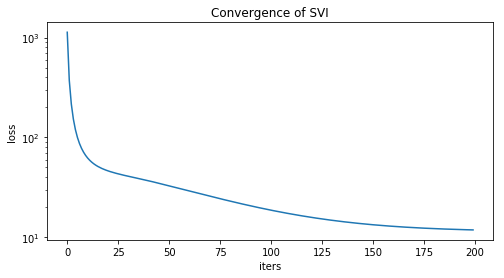

In [ ]:
pyplot.figure(figsize=(8,4)).set_facecolor('white')
pyplot.plot(iters, loss)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI')

Here are the learned parameters:

In [ ]:
ps = softmax(pyro.param('pre_ps'))
mu = pyro.param('mu')
sigma = pyro.param('sigma')
print('mu = {}'.format(mu.data.numpy()))
print('sigma = {}'.format(sigma.data.numpy()))

mu = [ 10.12377071   0.71275145]
sigma = [ 1.85083055]


And here is the learned mixture.

Text(0,0.5,u'probability density')

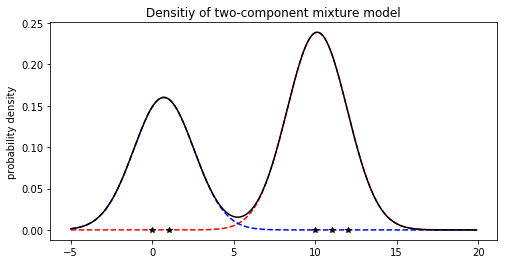

In [ ]:
X = np.arange(-5,20,0.1)
Y1 = ps.data[0] * scipy.stats.norm.pdf((X - mu.data[0]) / sigma.data[0])
Y2 = ps.data[1] * scipy.stats.norm.pdf((X - mu.data[1]) / sigma.data[0])

pyplot.figure(figsize=(8, 4)).set_facecolor('white')
pyplot.plot(X, Y1, 'r--')
pyplot.plot(X, Y2, 'b--')
pyplot.plot(X, Y1 + Y2, 'k-')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Densitiy of two-component mixture model')
pyplot.ylabel('probability density')